# Bikeshare 

In [14]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import inspect
import seaborn as sns 
import matplotlib.pyplot as plt

In [15]:
day = pd.read_csv('Bike-Sharing-Dataset/day.csv', index_col=0) 
hour = pd.read_csv('Bike-Sharing-Dataset/hour.csv', index_col=0)

data = [day, hour]

for df in data: # Change the coloumn names to something I feel more used to. 
    df.rename(columns={"dteday": "date", "cnt": "total_rentals", 'casual': 'casual_rentals', 'registered': 'registered_rentals', 'mnth':'month'}, inplace=True)


### Functions might be used to make my life easier:

In [16]:
def retrieve_name(var):
        """
        Gets the name of var. Does it from the out most frame inner-wards.
        :param var: variable to get name from.
        :return: string
        """
        for fi in reversed(inspect.stack()):
            names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
            if len(names) > 0:
                return names[0]

In [17]:
def missing(df):

    total = df.isnull().sum().sort_values(ascending=False)
    percent_1 = df.isnull().sum()/df.isnull().count()*100
    percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
    missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
    return missing_data.head(5)

In [18]:
def list_columns(df):
    for col in df: 
        print(col, end='   ')
        

In [19]:
def get_cname(df,col):
    return df.columns[df.columns.get_loc(col)]  # <--- Is ther a nicer way to do this?



In [20]:
day.columns[1]

'season'

In [21]:
df = day
col = 'season'
df.columns[df.columns.get_loc(col)]

'season'

In [22]:
list_columns(day)

date   season   yr   month   holiday   weekday   workingday   weathersit   temp   atemp   hum   windspeed   casual_rentals   registered_rentals   total_rentals   

In [23]:
def explore(*args):
    for arg in args:
        print('Data exploration for',retrieve_name(arg),':','\n')
        print(arg.info(),'\n')
        #print('Describe the data:\n',arg.describe().round(2),'\n')
        for col in arg:
            if len(arg[col].unique()) < 50:
                print('List unique values of column',col,':')
                print(arg[col].unique()) 
        print('\n','Missing Values:\n',missing(arg),'\n\n\n') 
        print('Column names for',retrieve_name(arg),':\n')
        for col_name in arg.columns: 
            print(col_name, end='   ')
        print('\n')

In [24]:
print("Hello there!", end = '')
print("It is a great day.")

Hello there!It is a great day.


### Targets

- Improve availability of bikes for working professionals / salaried employees as they are the most valued customers.
- Improve availability of bikes for casual customers.
- Provide statistics about contribution of weather in bike demands.
- Provide statistics about how traffic and pollution affect sales.



### Questions

- Is there a correlation between temp and feeled temp?
- Is there a correlation between temp, atemp and the toal bike rentals?
- Is there a correlation between season and feeled temp / temp?

## Data Exploration

In [25]:
explore(day, hour)

Data exploration for day : 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 731 entries, 1 to 731
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                731 non-null    object 
 1   season              731 non-null    int64  
 2   yr                  731 non-null    int64  
 3   month               731 non-null    int64  
 4   holiday             731 non-null    int64  
 5   weekday             731 non-null    int64  
 6   workingday          731 non-null    int64  
 7   weathersit          731 non-null    int64  
 8   temp                731 non-null    float64
 9   atemp               731 non-null    float64
 10  hum                 731 non-null    float64
 11  windspeed           731 non-null    float64
 12  casual_rentals      731 non-null    int64  
 13  registered_rentals  731 non-null    int64  
 14  total_rentals       731 non-null    int64  
dtypes: float64(4), int64(10), ob

## Preprocessing

### Categorize Data

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv


#### Original columns:

- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
 weathersit:
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

#### New columns:

- raw_tem
- raw_atemp
- raw_hum

### Data Transformation / Categorization 

In [26]:
# Categorizing numeric values and further transformation. 
# Adding ne columns. 

temp_categories = ['Death','Frigid','Freezing','Very Cold','Cold','Cool','Mild','Warm','Hot','Very Hot','Extremly Hot']
temp_categorie_values = [-100,-15,-10,-3,3,12,17,25,33,40,45,100] # <-- Can i set the outer limits to infinite? 

##y = 'hello'  deep copy and shallow copy 

# All mapings in this for loop will be applied to day and hour. 
for df in data: # Data has been defined data = [day, hour]
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')# <-- How to change the datetime format to '%d.%m.%Y' | This was changing the dtype --> .dt.strftime('%m/%d/%Y')
    #df['date'] = pd.dt.

    df['cat_season'] = df['season'].map({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})
    df['cat_is_holiday'] = df['holiday'].map({0:'No', 1:'Yes'})
    
    df['cat_yr'] = df['yr'].map({0:'2011', 1:'2012'})

    df['raw_temp'] = 39*df['temp']-(-8)*df['temp']+(-8)
    df['raw_atemp'] = 39*df['atemp']-(-16)*df['atemp']+(-16)
    df['raw_hum'] = df['hum']*100
    df['raw_windspeed'] = df['windspeed']*67

    df['cat_weathersit'] = df['weathersit'].map({1:'nice', 2:'cloudy', 3:'wet', 4:'lousy'})
    df['cat_temp'] = pd.cut(df['raw_temp'], temp_categorie_values, labels=temp_categories) # Depends on raw_temp
    df['cat_atemp'] = pd.cut(df['raw_atemp'], temp_categorie_values, labels=temp_categories) # Depends on raw_atemp

    df['cat_holiday'] = df['holiday'].map({1:'Yes', 0:'No'})
    df['cat_weekend'] = (df['date'].dt.weekday // 5).map({1:'Yes', 0:'No'})
    df['cat_workingday'] = (df['date'].dt.weekday // 5).map({1:'No', 0:'Yes'})
    
    df['cat_weekday'] = df['date'].dt.day_name() 
    df['cat_month'] = df['date'].dt.month_name()


SyntaxError: invalid syntax (<ipython-input-26-e1ee2c54a155>, line 12)

In [ ]:
#sns.pairplot(day)

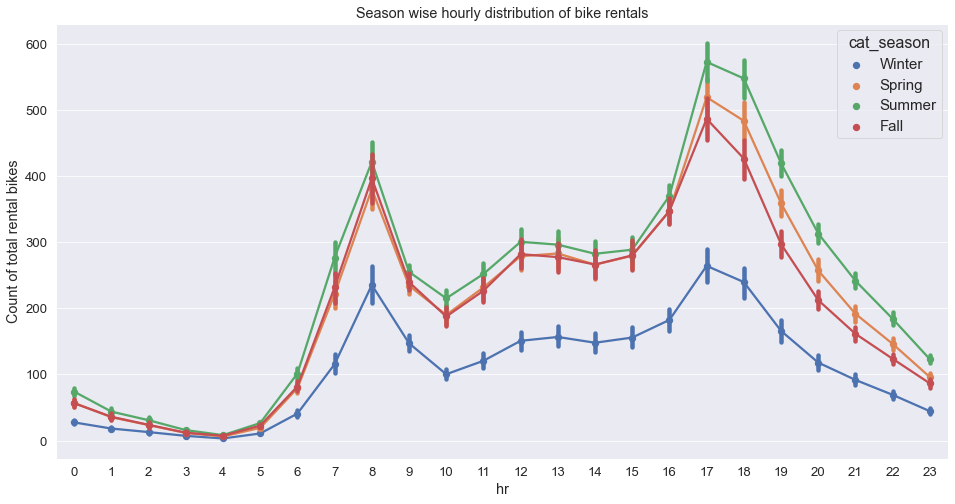

In [ ]:
sns.set(rc={'figure.figsize':(16,8)})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
#sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")
#sns.set_theme(style='darkgrid')
sns.set_style("darkgrid")
#fig, ax = plt.subplots()
ax = sns.pointplot(data = hour[['hr','total_rentals','cat_season']], x = 'hr', y = 'total_rentals',
              scale = 0.5, hue = 'cat_season');

plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set(title = 'Season wise hourly distribution of bike rentals',ylabel= 'Count of total rental bikes');

In [ ]:
list_columns(day)

date   season   yr   month   holiday   weekday   workingday   weathersit   temp   atemp   hum   windspeed   casual_rentals   registered_rentals   total_rentals   cat_season   cat_is_holiday   cat_yr   raw_temp   raw_atemp   raw_hum   raw_windspeed   cat_weathersit   cat_temp   cat_atemp   cat_holiday   cat_weekend   cat_workingday   cat_weekday   cat_month   

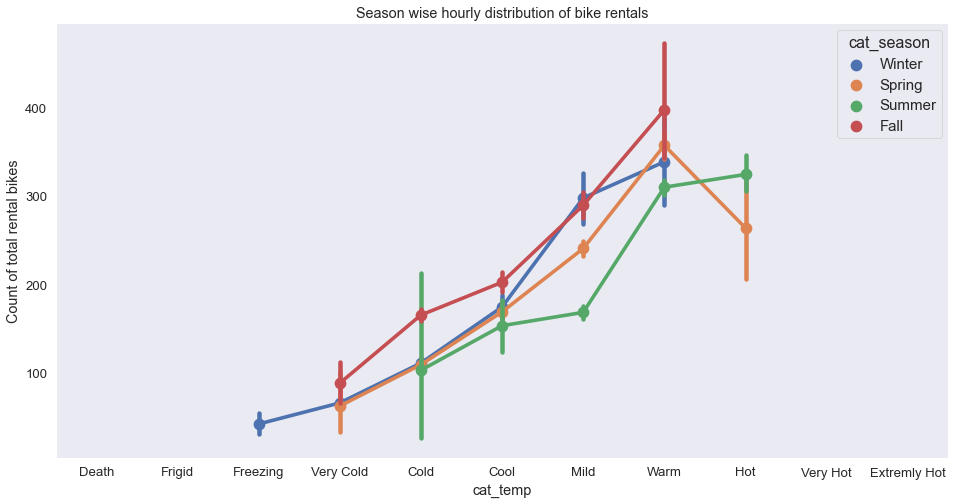

In [ ]:
sns.set(rc={'figure.figsize':(16,8)})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
#sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")
sns.set_style("dark")

#fig, ax = plt.subplots()
ax = sns.pointplot(data = hour[['cat_temp','total_rentals','cat_season']], x = 'cat_temp', y = 'total_rentals',
              scale = 0.8, hue = 'cat_season');

plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set(title = 'Season wise hourly distribution of bike rentals', ylabel= 'Count of total rental bikes');

<AxesSubplot:xlabel='cat_temp', ylabel='total_rentals'>

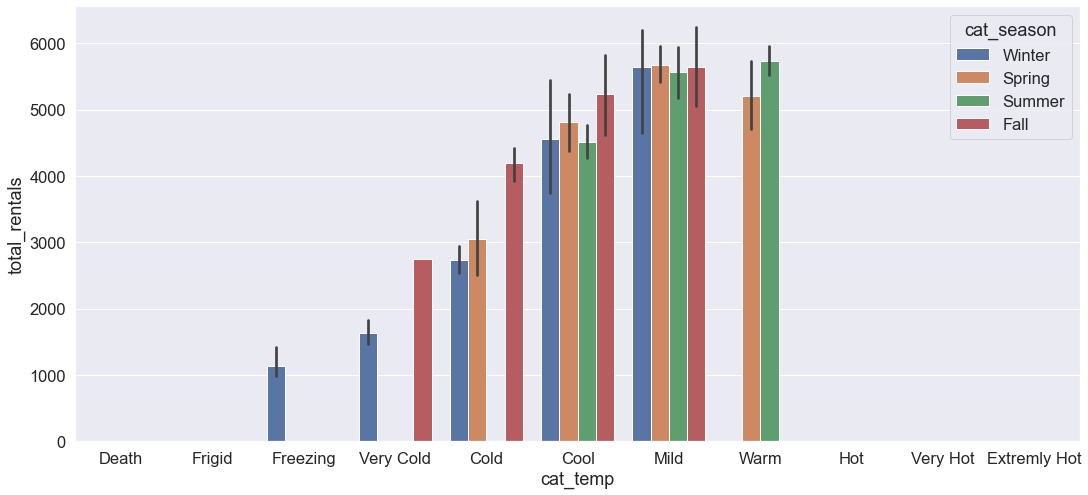

In [ ]:
sns.set(rc={'figure.figsize':(18,8)})
sns.set(font_scale=1.5)

sns.barplot(data=day, x="cat_temp", y="total_rentals", hue="cat_season")

# seperate in to 4 box plots 
# violin plot 

<AxesSubplot:xlabel='cat_temp', ylabel='total_rentals'>

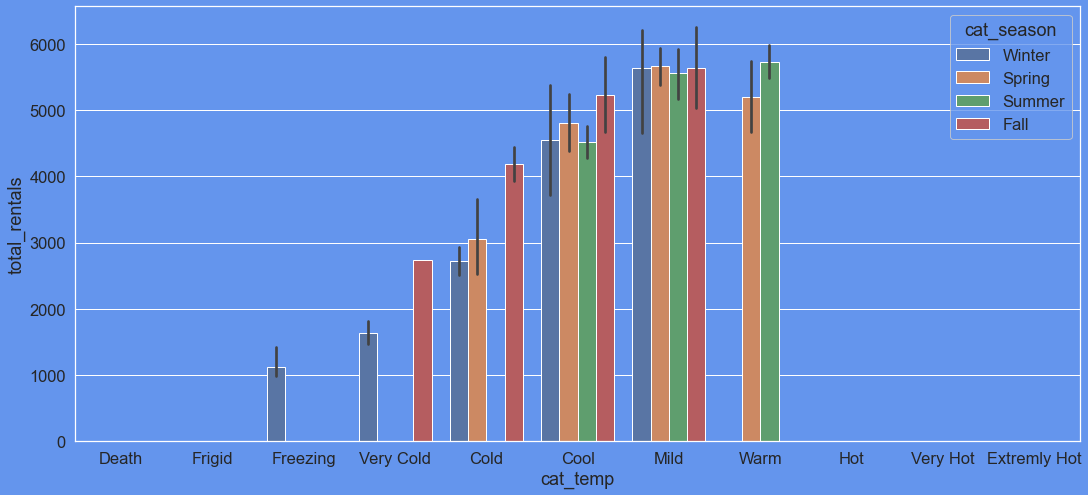

In [ ]:
sns.set(rc={'figure.figsize':(18,8), 'axes.facecolor':'cornflowerblue', 'figure.facecolor':'cornflowerblue'}, font_scale=1.5)

sns.barplot(data=day, x="cat_temp", y="total_rentals", hue="cat_season")

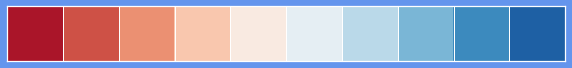

In [ ]:
diverging_colors = sns.color_palette("RdBu", 10)
sns.palplot(diverging_colors)

<AxesSubplot:xlabel='cat_season', ylabel='total_rentals'>

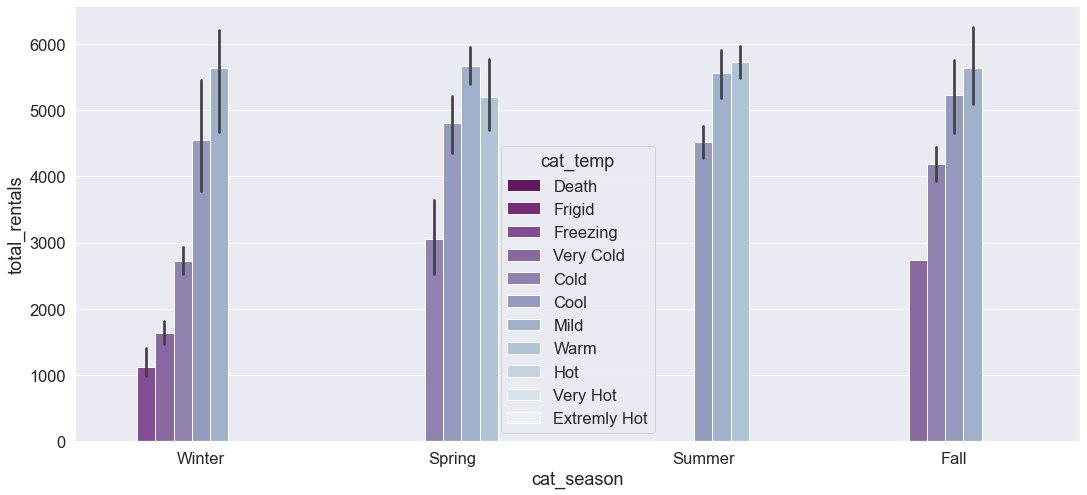

In [ ]:
sns.set(rc={'figure.figsize':(18,8)}) #re collor the bars
sns.set(font_scale=1.5)

sns.barplot(data=day, x="cat_season", y="total_rentals", hue="cat_temp", palette="BuPu_r")

<AxesSubplot:xlabel='cat_season', ylabel='total_rentals'>

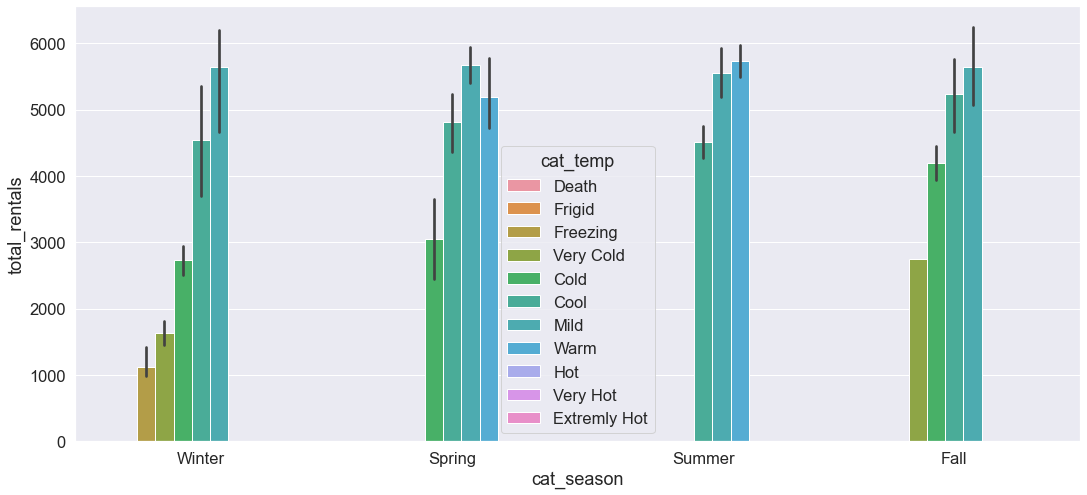

In [ ]:
sns.set(rc={'figure.figsize':(18,8)}) #re collor the bars
sns.set(font_scale=1.5)

sns.barplot(data=day, x="cat_season", y="total_rentals", hue="cat_temp")



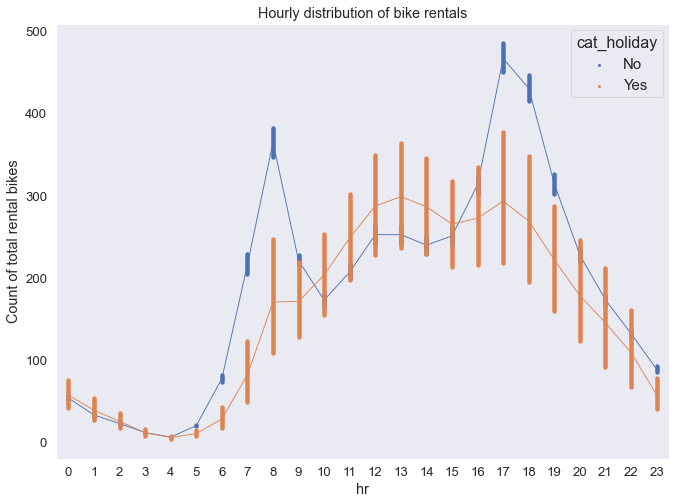

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
#sns.set(style="ticks", context="talk")
#plt.style.use("dark_background")
sns.set_style("dark")

#fig, ax = plt.subplots()
ax = sns.pointplot(data = hour[['hr','total_rentals','cat_holiday']], x = 'hr', y = 'total_rentals',
              scale = 0.2, hue = 'cat_holiday');

plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set(title = 'Hourly distribution of bike rentals',ylabel= 'Count of total rental bikes',);

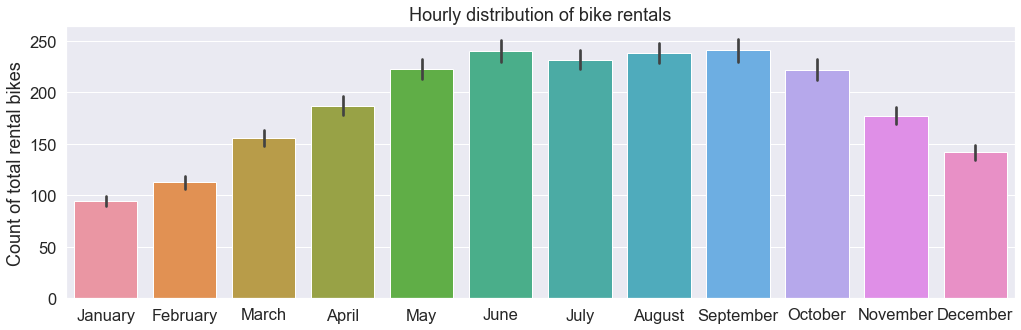

In [ ]:
sns.set(rc={'figure.figsize':(17,5)})
sns.set(font_scale = 1.5)

ax = sns.barplot(x="cat_month", y="total_rentals", data=hour,)
ax.set(title = 'Hourly distribution of bike rentals',ylabel='Count of total rental bikes', xlabel='');

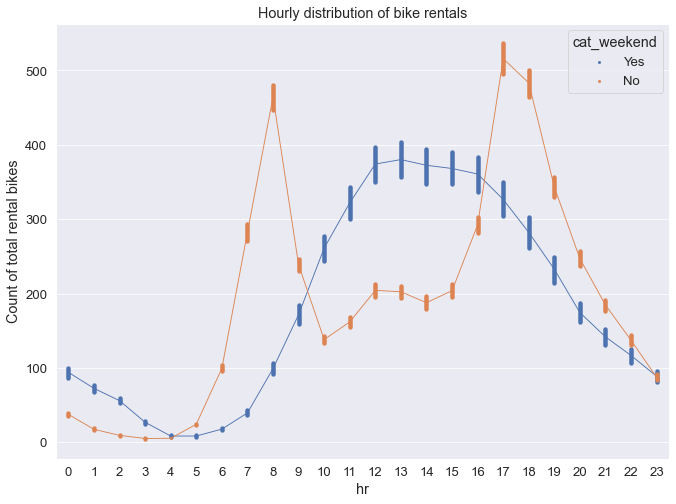

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

ax = sns.pointplot(data = hour[['hr','total_rentals','cat_weekend']], x = 'hr', y = 'total_rentals',
              scale = 0.2, hue = 'cat_weekend');

#plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

ax.set(title = 'Hourly distribution of bike rentals', ylabel= 'Count of total rental bikes');

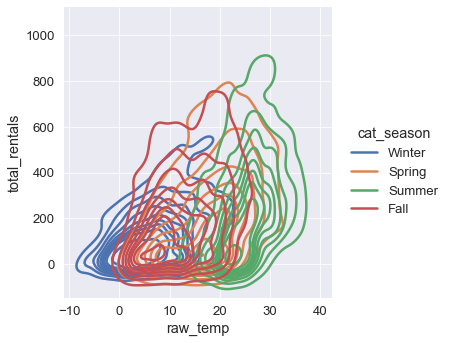

In [ ]:
sns.displot(hour, x="raw_temp", y="total_rentals", hue="cat_season", kind="kde")

NameError: name 'iris' is not defined

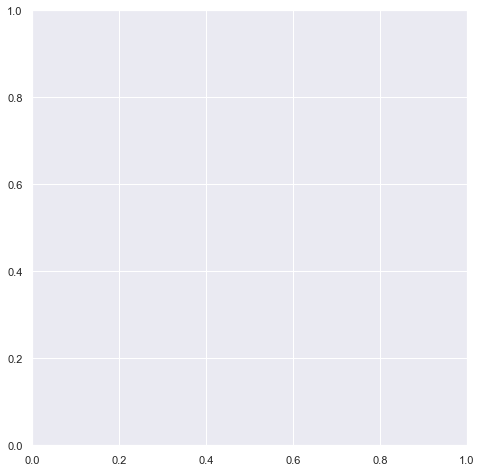

In [ ]:
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw a contour plot to represent each bivariate density
sns.kdeplot(
    data=iris.query("species != 'versicolor'"),
    x="sepal_width",
    y="sepal_length",
    hue="species",
    thresh=.1,
)

In [ ]:
sns.set_theme(style="ticks")

# Show the joint distribution using kernel density estimation
g = sns.jointplot(hour, x="raw_temp", y="total_rentals", hue="cat_season", kind="kde")

# What i want to do:

